# Quick Technical Analysis
This notebook is a quick technical analysis demonstration. This notebook was built in under a day and serves as a preliminary skills demo. The purpose of the demonstration is to show understanding of data analysis concepts and techniques. Actual coding can be transfered between software (R, Python, Tableau, etc.). Jupyter Markdown is used as GitHub does not render R Markdown files.

The core contents of this notebook include:
-  Understanding Data and Planning Analysis
-  Data Modelling
-  Prediction and Forecasting

## Libraries
Scikit-learn is used for data analysis. Tensorflow is used for data modelling. Pandas is used in place of R for data manipulation. Matplotlib is used for visualising the data. Numpy is used for scientific calculations and formatting.

In [136]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

## Understanding Data and Planning Analysis
We want to start by understand the data we are working with, and coming up with a plan on how to analyse it. A [sample dataset](https://www.ibm.com/communities/analytics/watson-analytics-blog/sales-products-sample-data/) of sales from Watson Analytics is used. Usually we would want some context for the data  (e.g. knowing where the data is pulled from and description for each category), but in this case the dataset does not provide any useful descriptions. That leaves it up to us to make sense of the data.

To begin, we want to see what the data actually contains.

In [91]:
sales_data = pd.read_csv("WA_Sales_Products_2012-14.csv")
sales_data.head(n=5)

,Retailer country,Order method type,Retailer type,Product line,Product type,Product,Year,Quarter,Revenue,Quantity,Gross margin
0,United States,Fax,Outdoors Shop,Camping Equipment,Cooking Gear,TrailChef Deluxe Cook Set,2012,Q1 2012,59628.66,489,0.347548
1,United States,Fax,Outdoors Shop,Camping Equipment,Cooking Gear,TrailChef Double Flame,2012,Q1 2012,35950.32,252,0.474274
2,United States,Fax,Outdoors Shop,Camping Equipment,Tents,Star Dome,2012,Q1 2012,89940.48,147,0.352772
3,United States,Fax,Outdoors Shop,Camping Equipment,Tents,Star Gazer 2,2012,Q1 2012,165883.41,303,0.282938
4,United States,Fax,Outdoors Shop,Camping Equipment,Sleeping Bags,Hibernator Lite,2012,Q1 2012,119822.20,1415,0.291450


We can see that the dataset contains a wide variety of categories we may want to perform analysis and model data with. A basic summary of the columns can be a good way to understand the data, make sure the data is already cleaned, and serve as an initial check for some KPI's. Some examples of what we may want to know include:
- What Order methods are included in the dataset 
- The range of revenues in any quarter
- The maximum revenue a store in the United States has made in 2012 
- The average gross margin of fax based orders
- Are there any invalid values / errors for quantity

In [92]:
print("Order Methods: ",sales_data['Order method type'].unique())
print("Range of revenue is between {} and {}".format(sales_data['Revenue'].min(),sales_data['Revenue'].max(), " Min: "))
print("Maximum Revenue in US in 2012: ",sales_data[sales_data.Year == 2012]['Revenue'].max())
print("Average Gross Margin for fax orders: ",sales_data[sales_data['Order method type'] == 'Fax']['Gross margin'].mean())
print("Result of invalid values check on quantity: ",pd.isnull(sales_data['Quantity'].any()))

Order Methods:  ['Fax' 'Telephone' 'Mail' 'Web' 'Sales visit' 'Special' 'E-mail']
Range of revenue is between 0.0 and 1635687.96
Maximum Revenue in US in 2012:  1210413.68
Average Gross Margin for fax orders:  0.4512584834480677
Result of invalid values check on quantity:  False


We can also do comparisons of values. For instance, we may want to know the composition of order methods for each country:

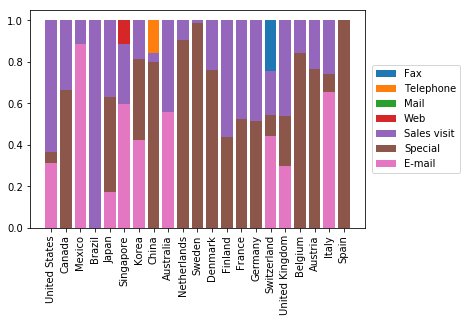

In [93]:
countries = sales_data['Retailer country'].unique()
methods = sales_data['Order method type'].unique()
count_table = np.zeros((len(methods),len(countries)))

#Counts number of rows for each method in each country
for m in range(len(methods)):
    for c in range(len(countries)):
        count_table[m-1,c-1] = sales_data[(sales_data['Retailer country'] == countries[c-1]) & (sales_data['Order method type'] == methods[m-1])]['Revenue'].mean()
        if np.isnan(count_table[m-1,c-1]):
            count_table[m-1,c-1] = 0

#Normalizes the value of counts
for c in range(len(countries)):
    col_max = count_table[:,c-1].max()
    for m in range(len(methods)):
        count_table[m-1,c-1] = count_table[m-1,c-1] / col_max

x = np.arange(len(countries))
for m in range(len(methods)): 
    plt.bar(x, count_table[m-1,:])
plt.legend(methods, loc = 'right', bbox_to_anchor=(1.3,0.5))
plt.xticks(x,countries,rotation = 'vertical')
plt.show()

We can already see some interesting facts about the data, such as Brazil and Spain being dominated by only one method of ordering (We can also easily check if this is true). We can also see that web, telephone, and fax orders only have presence in one respective market each. Depending on the questions we want answered, this can give us a lot of insight and give a plan for analysis. 

Of course further analysis is always needed to get a better understanding of the data. Just looking at the graph, it seems as though Sales visits and special orders are almost equally important contributors to revenue. However, when we take a closer look at the data...

In [94]:
print("Sales visit revenue: ",sales_data[sales_data['Order method type'] == 'Sales visit']['Revenue'].sum())
print("Special order revenue: ",sales_data[sales_data['Order method type'] == 'Special']['Revenue'].sum())

Sales visit revenue:  209122112.89999998
Special order revenue:  13445401.5


We can see that they are quite far apart (about 20 to 1 difference).


## Data Modelling

We may also be interested in modelling the data. After all, summaries can only go so far, and modelling data can give even more insight into all the interconnected relationships inside the data. Another [sample dataset](https://www.kaggle.com/karangadiya/fifa19) from Kaggle is used. This data contains information about the in-game FIFA 19 player characters (Not real-life customers). 

In [95]:
fifa_data = pd.read_csv("FIFA19_data.csv")
fifa_data.head(n=5)

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


Let's consider if FIFA 19 gave real-life players the ability to make their own playable character in FIFA 19! They might give the player a series of challenges in game to determine the character stats, or make it based off the real-life player's lifetime stats. But now we want to determine what the character should cost to the player. Luckily for us, there's a huge set of data with characters, their stats, and their respective wages right at our fingertips.

I am going to choose some initial predictor variables to work with due to time constraints, however given enough time for analysis, this does not have to be done. We will use ID, Age, Potential, International Reputation, Preferred Foot, Height, Wage, and Value. 

In [96]:
fifa_data_1 = fifa_data[['ID','Age','Potential','Value','Wage','International Reputation','Preferred Foot','Height']]
fifa_data_1.head(n=5)

,ID,Age,Potential,Value,Wage,International Reputation,Preferred Foot,Height
0,158023,31,94,€110.5M,€565K,5.0,Left,5'7
1,20801,33,94,€77M,€405K,5.0,Right,6'2
2,190871,26,93,€118.5M,€290K,5.0,Right,5'9
3,193080,27,93,€72M,€260K,4.0,Right,6'4
4,192985,27,92,€102M,€355K,4.0,Right,5'11


### Data Cleaning

Now, we want to clean up the data so that all the values are numerical and workable. We will convert any currency value into number in thousands. The height will be converted to inches. We can also give a value to preferred foot: left = 0 and right = 1.

In [97]:
#Data Manipulation and Cleaning Functions
def curr_value(input_str):
    if input_str[-1] == 'K':
        return float(input_str[1:-1])
    elif input_str[-1] == 'M':
        return (float(input_str[1:-1])*1000)
    else:
        return 0

def foot_value(foot_str):
    if foot_str == 'Left':
        return 0
    elif foot_str == 'Right':
        return 1
    else:
        pass

def height_value(height_str):
    try:
        height_str = height_str.split("'")
        return float(height_str[0])*12 + float(height_str[1])
    except:
        pass

#Manipulating Dataframe using Numpy
fifa_data_1 = fifa_data_1.dropna().to_numpy() #Shortcut for time management - Not recommended to drop na provided enough time
for r in range(fifa_data_1.shape[0]):
    fifa_data_1[r-1,3] = curr_value(fifa_data_1[r-1,3])
    fifa_data_1[r-1,4] = curr_value(fifa_data_1[r-1,4])
    fifa_data_1[r-1,6] = foot_value(fifa_data_1[r-1,6])
    fifa_data_1[r-1,7] = height_value(fifa_data_1[r-1,7])

#Creates Pandas DataFrame for easy reference
clean_fifa = pd.DataFrame(fifa_data_1)
clean_fifa = clean_fifa.rename(columns = {0:'ID',1:'Age',2:'Potential',3:'Value',4:'Wage',5:'International Reputation',6:'Preferred Foot',7:'Height'})
clean_fifa.head(n=5)

,ID,Age,Potential,Value,Wage,International Reputation,Preferred Foot,Height
0,158023,31,94,110500,565,5,0,67
1,20801,33,94,77000,405,5,1,74
2,190871,26,93,118500,290,5,1,69
3,193080,27,93,72000,260,4,1,76
4,192985,27,92,102000,355,4,1,71


### Regression Models and Analysis

Now we can begin to fit models with the data. While I am more familiar with data analysis using R, as there are more in depth summaries, graphs, and guides, data analysis can still be performed using SKLearn. 

In [98]:
from sklearn import linear_model
lm = linear_model.LinearRegression()
X = fifa_data_1[:,[1,2,3,5,7]]
Y = fifa_data_1[:,4]
lm.fit(X,Y)
print("Intercept: ",lm.intercept_)
print("Coefficients: ",lm.coef_)

Intercept:  -19.972913701192056
Coefficients:  [2.04784423e-01 2.83035457e-02 2.90176034e-03 9.63382812e+00
 6.76358204e-02]


While it may seem that an increase in international reputation has the strongest correlation with increases in wages, we must consider the range of values of each predictor. With a maximum international reputation of 5, the wage can increase by ~48.1929. In contrast, a value of 16609 adds ~48.1947 in this specific model.

Scatterplots can give more insight on this interaction.

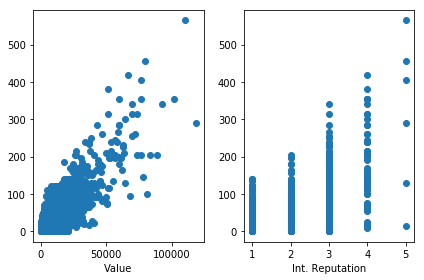

In [99]:
plt.subplot(1, 2, 1)
plt.scatter(fifa_data_1[:,3],Y)
plt.xlabel('Value')

plt.subplot(1, 2, 2)
plt.scatter(fifa_data_1[:,5],Y)
plt.xlabel('Int. Reputation')
plt.tight_layout()
plt.show()

We can see that an increase in value increases both the minimum and maximum wages, while increases in reputation only affect the maximum wages. 

Now let's take a look at height when plotted against wages.

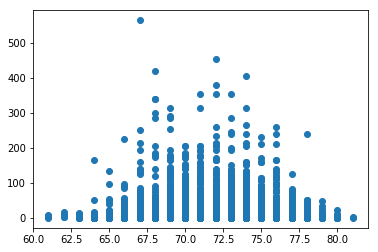

In [100]:
plt.scatter(fifa_data_1[:,7],Y)

From first glance, it may appear as though outliers for height (those who are extremely short or extremely tall) are at a disadvantage when it comes to wages. However we should also consider that there are far fewer outliers and the lack of highly paid outlier could be due to chance. We can see the distribution of wages with a histogram, using counts to save on machine processing.

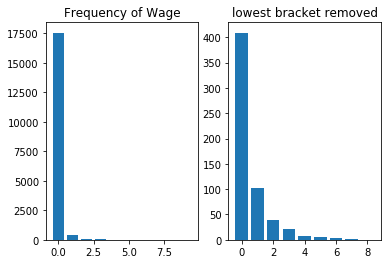

In [101]:
Y_test = np.sort(Y)
Y_count = []
counter = 0
bin_index = 50

#Counts the Number of Observations in a bin size of 50
for i in range(len(Y_test)):
    if (Y_test[i] < bin_index):
        counter+=1
    elif (Y_test[i] >= bin_index):
        bin_index+=50
        Y_count.append(counter)
        counter=0
    i+=1
x1 = np.arange(len(Y_count))
x2 = np.arange(len(Y_count)-1)

plt.subplot(1, 2, 1)
plt.bar(x1,Y_count)
plt.title("Frequency of Wage")

plt.subplot(1, 2, 2)
plt.bar(x2,Y_count[1:])
plt.title("lowest bracket removed")
plt.show()

Each bar represents a 20000 euro increase in wage. We can see that the probability of any person having a high wage is already miniscule, on top of the probability of being an outlier in height. We can reasonably conclude that it may be coincidence that the two events have not occured together. Many techniques can also be employed to very if this is accurate, including probability calculations and simulations.

Say perhaps we are not so sure how much height actually contributes to weight, and there is suspicious that height does not contribute positively to the model (i.e. it may be overfitting). We would want to make a model without height and check its performance on new data against our original model. There are many ways we can check and compare models. Comparing standard errors, new data residuals, ANOVA/deviance, cross validation, and LASSO & Bootstrap are just some of the methods employable. Model testing through R proves to be a much more manageable task than through Scikit-Learn. 

### Cluster Models

We may be interested in seeing if there are any significant clustering patterns in our data. It can be a good way of learning group patterns (e.g. a species of Deers preferring tall grass more than other species) or getting more information out of a limited dataset. While the dataset given previously does not have significant opportunity for cluster and classification analysis, the classic [iris dataset](https://archive.ics.uci.edu/ml/datasets/iris) from UCI Machine Learning Repository is tailored towards clustering. This dataset has been employed by many data scientists and statisticians over the years to test models.

In [113]:
iris_data = pd.read_csv('iris.csv')
iris_data.head(n=5)

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [114]:
print(iris_data['class'].unique())

['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000171E12CCC50>,
      dtype=object)

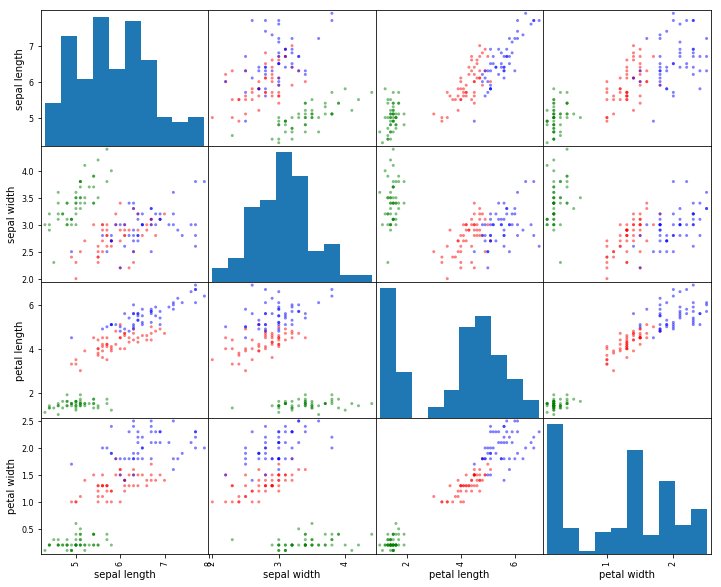

In [115]:
colors = {'Iris-setosa':'green', 'Iris-versicolor':'red', 'Iris-virginica':'blue'}

pd.plotting.scatter_matrix(iris_data, c=iris_data['class'].apply(lambda x: colors[x]), figsize=(12,10))

We can see why everyone loves to use this dataset. The groups are easily distinguishable, which makes it more simple to identify problems and fixes in new algorithms and techniques. 

As a tool, clustering can give valuable insight into discrete information. Perhaps you want to see if there are any ways to distinguish between revenue generating visitors and non-revenue visitors. Or maybe you want to predict a person's browsing platform based on their browsing habits. Given the data, those types of questions can be further explored with clustering.

Now, suppose new data was into the iris dataset, but the class was lost! In this case, we can try and predict the class with clustering. To begin, we use KNN with a neighbor of 3.

In [123]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(iris_data[['sepal length','sepal width']],iris_data['class'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

This model should be able to fit new data. For instance, say we have a new flower measurement with a sepal length of 5.8 and width of 3.7. Looking closer at the graph of sepal length vs sepal width:

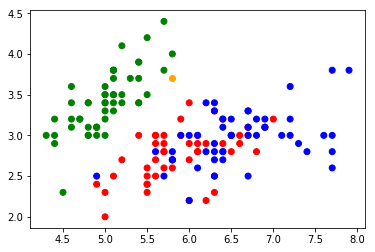

In [131]:

plt.scatter(iris_data['sepal length'],iris_data['sepal width'], c=iris_data['class'].apply(lambda x: colors[x]))
plt.scatter(5.8,3.7,c = 'orange')

The new point (highlighted orange) seems to most likely be part of the green setosa class. And if we predict using the KNN model:

In [135]:
print(knn.predict([[5.8,3.7]]))

['Iris-setosa']


We can see that is what the model predicts. Most clustering techniques can model with both supervised (As in this case) or unsupervised learning, and can be generalised for far more than one data point.


## Prediction and Forecasting

The model above uses euclidean distance and only predicts for 2 input variables. But euclidean distance is useless for discrete non-numerical data. What if we wanted to predict for categories using discrete non-euclidean data? We can build a more advanced model using the dataset above and neural networks. Many concepts are interchangeable between regular regression models and neural networks. 

In this case, we can fit a simple feed-forward neural network. First, the data must be prepared and paremeters set. In the case of training and testing a model, it is usually a good idea to divide pre-existing data by either 50/25/25 for train/cross-validate/test or 70/30 for just train/test. As we are already pretty low on data, I will be using a 70/30 split.

In [196]:
from sklearn.utils import shuffle

#Creates labels for Classes
class_label = {'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2}

#Randomly Shuffles Data 
random_sample = shuffle(iris_data)
random_sample['class'] = random_sample['class'].apply(lambda x: class_label[x])
max_size = np.max(np.amax(random_sample))

#Separates into 70/30
div_1 = int(len(random_sample.index)*0.7)

train_data = random_sample[['sepal length','sepal width','petal length','petal width']][:div_1].to_numpy()/max_size
train_label = random_sample[['class']][:div_1].to_numpy()
test_data = random_sample[['sepal length','sepal width','petal length','petal width']][div_1+1:].to_numpy()/max_size
test_label = random_sample[['class']][div_1+1:].to_numpy()

Now we can fit the model:

In [198]:
model = keras.Sequential([
    #keras.layers.Flatten(input_shape=(4,)),
    keras.layers.Dense(5, activation=tf.nn.relu, input_shape=(4,)),
    keras.layers.Dense(6, activation=tf.nn.sigmoid),
    keras.layers.Dense(3, activation=tf.nn.softmax)
])
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

history = model.fit(train_data,train_label, epochs = 50)

Epoch 1/50
105/105 [==============================] - 0s 3ms/sample - loss: 1.1951 - acc: 0.3524
Epoch 2/50
105/105 [==============================] - 0s 67us/sample - loss: 1.1761 - acc: 0.3524
Epoch 3/50
105/105 [==============================] - 0s 67us/sample - loss: 1.1477 - acc: 0.3524
Epoch 4/50
105/105 [==============================] - 0s 67us/sample - loss: 1.1264 - acc: 0.3524
Epoch 5/50
105/105 [==============================] - 0s 57us/sample - loss: 1.1079 - acc: 0.3524
Epoch 6/50
105/105 [==============================] - 0s 57us/sample - loss: 1.0985 - acc: 0.3619
Epoch 7/50
105/105 [==============================] - 0s 67us/sample - loss: 1.0902 - acc: 0.3429
Epoch 8/50
105/105 [==============================] - 0s 67us/sample - loss: 1.0881 - acc: 0.3429
Epoch 9/50
105/105 [==============================] - 0s 67us/sample - loss: 1.0880 - acc: 0.3429
Epoch 10/50
105/105 [==============================] - 0s 57us/sample - loss: 1.0865 - acc: 0.3429
Epoch 11/50
105/105 

We can now check the model's fit history over time:


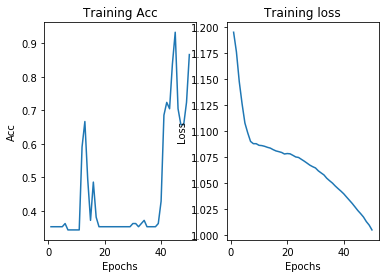

In [202]:
history_dict = history.history

acc = history_dict['acc']
loss = history_dict['loss']

epochs = range(1, len(acc) + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs, acc)
plt.title('Training Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss)
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

We can see that the accuracy of the model is very unstable even as the training loss is constantly decreasing. This may be an effect of a small dataset, and may be a sign of excess overfitting in the model. So, we test the model with the testing subset.

In [207]:
predictions = model.predict(test_data)
accCount = 0

for i in range(len(test_label)):
    if np.argmax(predictions[i]) == test_label[i]:
        accCount+=1

print("Testing accuracy is {}%".format(accCount*100/len(test_label)))

Testing accuracy is 77.27272727272727%


Our model is some degree of overfitting, since the accuracy on the training data was 86.67%. With that being said, an accuracy of 77% is still pretty good for a simple model. 

Graphing for two predictors for simplicity:

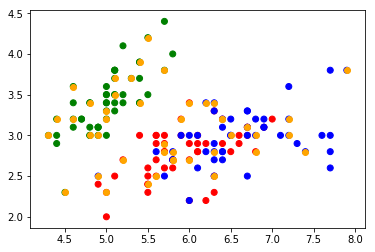

In [221]:
plt.scatter(iris_data['sepal length'],iris_data['sepal width'], c=iris_data['class'].apply(lambda x: colors[x]))
plt.scatter(test_data[:,0]*max_size,test_data[:,1]*max_size,c='orange')

The orange data points are testing data points, and were not used to fit the model. And showing which of the data points were predicted incorrectly:

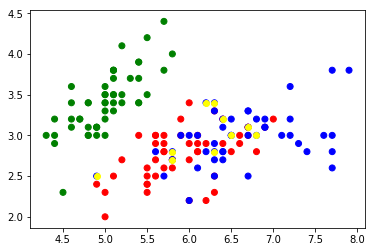

In [247]:
wrong_predictions = np.zeros((len(test_label)-accCount,4))
counter = 0

for i in range(len(test_label)):
    if not (np.argmax(predictions[i]) == test_label[i]):
        for c in range(4):
            wrong_predictions[counter,c-1] = test_data[i,c-1]
        counter+=1

plt.scatter(iris_data['sepal length'],iris_data['sepal width'], c=iris_data['class'].apply(lambda x: colors[x]))
plt.scatter(wrong_predictions[:,0]*max_size,wrong_predictions[:,1]*max_size,c='yellow')


We can see that the datapoints that the model incorrectly predicted are reasonably difficult to predict for.